In [1]:
%autosave 0
import numpy as np
import pandas as pd

Autosave disabled


# <center>Data Overview</center>

In [2]:
# https://www.kaggle.com/datasets/mukeshmanral/univariate-time-series
ts = pd.read_csv('date_count.csv')

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [4]:
ts

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


### Preprocessing

In [5]:
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

### Time series plot

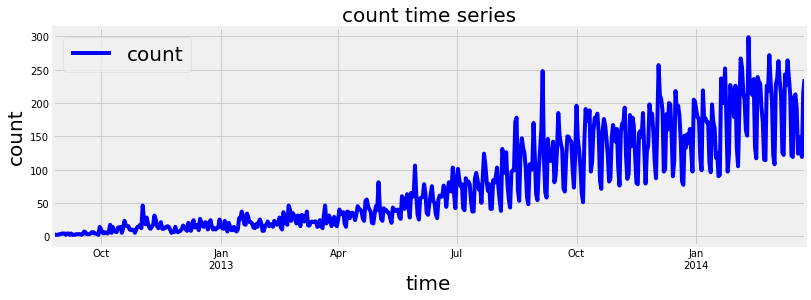

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

ts.plot(color='blue')
plt.title('count time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('count', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

### Time series decomposition

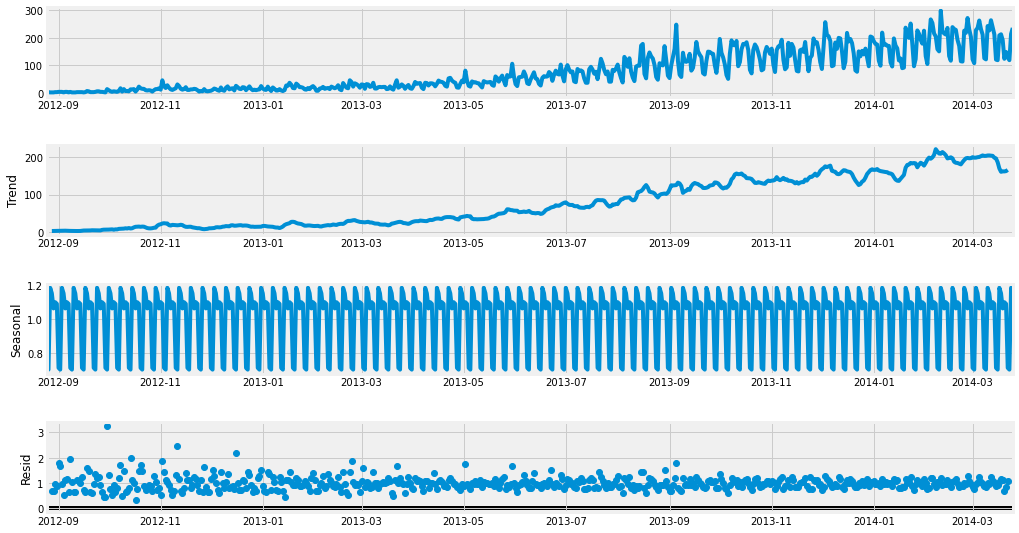

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.asfreq('D')
decompose = seasonal_decompose(ts, model='multiplicative')
decompose.plot()
plt.gcf().set_size_inches(16, 8)
plt.show()

Let's have a closer look at the seasonality.

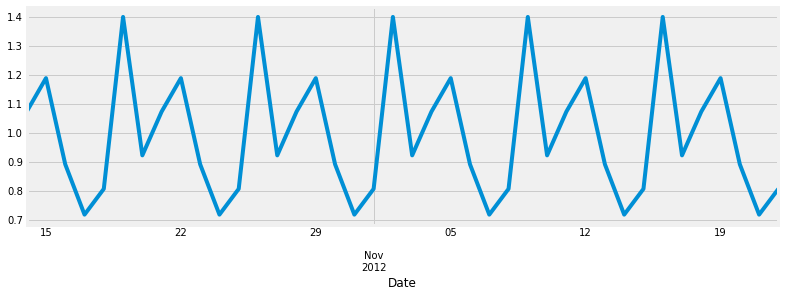

In [8]:
magified_seasonality = ts.iloc[50:90]
magified_seasonality.asfreq('D')
decomp = seasonal_decompose(magified_seasonality, model='multiplicative')
decomp.seasonal.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

It is now evident that weekly seasonality is present.

# <center>Multi-step 60-day forecast (fh = 60)</center>

### Train / test split

In [9]:
y_train = ts.iloc[:len(ts)-60]
y_test = ts.iloc[len(ts)-60:]

### Training / Forecasting

In this case, we want to employ sklearn to perform forecasting. Data is tabularized for complianace with regressors. Also, we will use ForecastingGridSearchCV in order to hypertune sklearn algos, before picking the best one as our forecaster. 

In [10]:
hypergrid = {
    'gbr': {
        "estimator__learning_rate":[0.001, 0.01, 0.1, 0.2, 0.5],
        "estimator__warm_start":[True, False]        
    },
    'enet': {
        "estimator__alpha":[0.01, 0.1, 0.3, 0.5, 0.75],
        "estimator__warm_start":[True, False],
        "estimator__l1_ratio":[0.2, 0.35, 0.5, 0.7, 0.9]
    },
    'RandForest': {
        "estimator__n_estimators":[30, 50, 100, 150],
        "estimator__warm_start":[True, False]
    },
    'gpr': {
        "estimator__n_restarts_optimizer":[0, 1, 2, 3],
    },
    'knn_reg': {
        "estimator__weights":['uniform', 'distance'],
        "estimator__n_neighbors":[1 , 2 , 3]
    }
}

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor

regressors = {
    'gbr': GradientBoostingRegressor(),
    'enet': ElasticNet(),
    'RandForest': RandomForestRegressor(criterion='absolute_error'),
    'gpr': GaussianProcessRegressor(),
    'knn_reg': KNeighborsRegressor()
}

In [12]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# tabularization
from sktime.forecasting.compose import make_reduction

# hypertuning
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,ExpandingWindowSplitter)

y_train = y_train.asfreq('D')
fit_models = {}
for algo in regressors.keys():
    regressor = regressors[algo]
    forecaster = make_reduction(regressor, strategy="direct", window_length=7)
    fh_cv=ForecastingHorizon(np.arange(1, 31))
    cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train) - 150), step_length=30)
    fgscv = ForecastingGridSearchCV(
        forecaster, 
        cv=cv, 
        param_grid=hypergrid[algo], 
        scoring=MeanAbsolutePercentageError(symmetric=True))
    fh=ForecastingHorizon(np.arange(1, 61))
    fgscv.fit(y_train, fh=fh)
    fit_models[algo]=fgscv

In [13]:
best_MAPE=1000
for algo in regressors.keys():
    y_pred = fit_models[algo].predict(fh)
    MAPE = float(np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
    if MAPE < best_MAPE:
        best_MAPE = MAPE
        best_algo = algo

In [15]:
fit_models[best_algo].best_forecaster_

DirectTabularRegressionForecaster(estimator=ElasticNet(alpha=0.01, l1_ratio=0.2,
                                                       warm_start=True),
                                  window_length=7)

In [16]:
y_pred = fit_models[best_algo].predict(fh)

### Evaluation

In [22]:
df = y_test.assign(y_pred=y_pred)

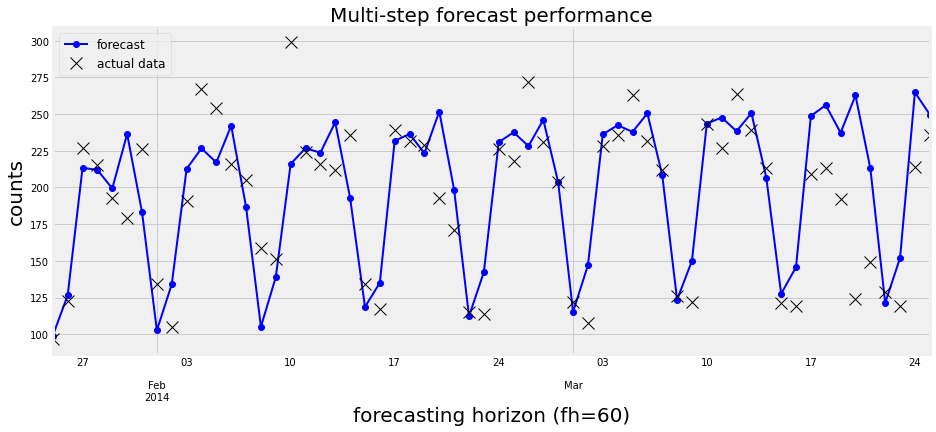

In [29]:
df['y_pred'].plot(label='forecast', color='blue', marker='o', linewidth=2)
df['count'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.title('Multi-step forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=60)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [26]:
df.columns

Index(['count', 'y_pred'], dtype='object')

In [27]:
def evaluation_metrics(y_test, y_pred, model_name):
    MAPE = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'Model':model_name, 'MAPE':round(MAPE,3), 'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

accuracy = evaluation_metrics(df['count'], df['y_pred'], 'ElasticNet')
print(accuracy)

{'Model': 'ElasticNet', 'MAPE': 14.292, 'RMSE': 34.41, 'MAE': 24.855}


In [28]:
performance_summary_fh60 = pd.read_csv('performance_summary_fh60.csv')
performance_summary_fh60 = performance_summary_fh60.append(accuracy, ignore_index=True)
performance_summary_fh60.to_csv('performance_summary_fh60.csv', index=False)

# <center>Rolling 1-day forecasting (fh=1)</center>

### Training / Forecasting

We will make use of ExpandingWindowSplitter() and evaluate() to conduct forecasting.

In [31]:
from sktime.forecasting.model_evaluation import evaluate

ts = ts.asfreq('D')
regressor = ElasticNet(alpha=0.01, l1_ratio=0.2, warm_start=True)
forecaster = make_reduction(regressor, window_length=7, strategy="direct")
cv = ExpandingWindowSplitter(initial_window=int(len(ts)-60), step_length=1) # default: fh=1
evaluation_df = evaluate(forecaster=forecaster, y=ts, cv=cv, strategy="refit", return_data=True)

In [32]:
evaluation_df.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.055624,0.005704,0.001998,518,2014-01-24,count 2012-08-25 3 2012-08-26...,count 2014-01-25 97,count 2014-01-25 102.395548
1,0.001065,0.004986,0.001700,519,2014-01-25,count 2012-08-25 3 2012-08-26...,count 2014-01-26 123,count 2014-01-26 122.869051
2,0.105355,0.005117,0.001756,520,2014-01-26,count 2012-08-25 3 2012-08-26...,count 2014-01-27 227,count 2014-01-27 203.08447
3,0.000263,0.004960,0.001898,521,2014-01-27,count 2012-08-25 3 2012-08-26...,count 2014-01-28 215,count 2014-01-28 215.056455
4,0.090148,0.004949,0.001713,522,2014-01-28,count 2012-08-25 3 2012-08-26...,count 2014-01-29 193,count 2014-01-29 210.398613


In [33]:
evaluation_df.shape

(60, 8)

In [38]:
type(evaluation_df.y_test[0])

pandas.core.frame.DataFrame

In [41]:
evaluation_df.y_test[0].shape

(1, 1)

Well, it looks like some additional job is neccessary to retrieve our data. Also, we will create accurate index in terms of predictions rather than cutoff. 

In [42]:
evaluation_df.set_index('cutoff', inplace=True)
evaluation_df.index = evaluation_df.index.shift(periods=1, freq='D')

i=0
while i < len(evaluation_df):
    evaluation_df.y_test[i] = int(evaluation_df.y_test[i].values)
    evaluation_df.y_pred[i] = float(evaluation_df.y_pred[i].values)
    i+=1

<ipython-input-42-7ec6c158d830>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df.y_test[i] = int(evaluation_df.y_test[i].values)
<ipython-input-42-7ec6c158d830>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df.y_pred[i] = float(evaluation_df.y_pred[i].values)


In [43]:
evaluation_df.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,y_train,y_test,y_pred
cutoff,,,,,,,
2014-01-25,0.055624,0.005704,0.001998,518,count 2012-08-25 3 2012-08-26...,97,102.395548
2014-01-26,0.001065,0.004986,0.001700,519,count 2012-08-25 3 2012-08-26...,123,122.869051
2014-01-27,0.105355,0.005117,0.001756,520,count 2012-08-25 3 2012-08-26...,227,203.08447
2014-01-28,0.000263,0.004960,0.001898,521,count 2012-08-25 3 2012-08-26...,215,215.056455
2014-01-29,0.090148,0.004949,0.001713,522,count 2012-08-25 3 2012-08-26...,193,210.398613


Now we are ready to plot the results and calculate metrics.

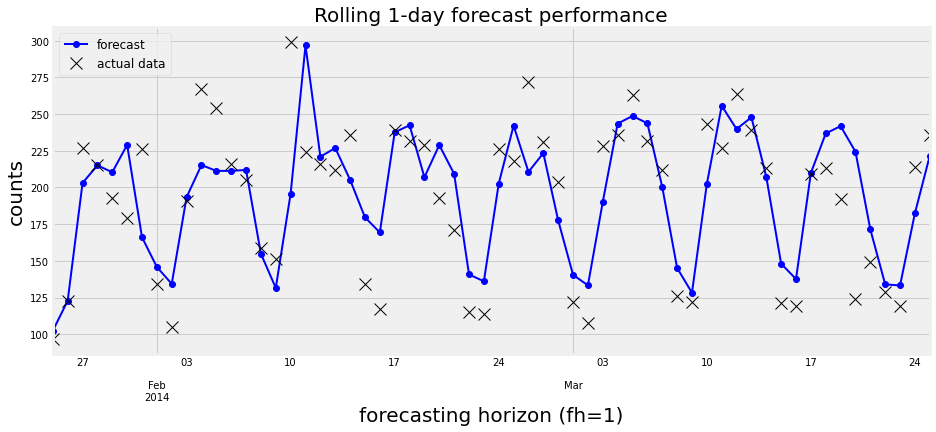

In [44]:
evaluation_df['y_pred'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.title('Rolling 1-day forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=1)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [45]:
accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['y_pred'], 'ElasticNet')
print(accuracy)

{'Model': 'ElasticNet', 'MAPE': 14.145, 'RMSE': 33.596, 'MAE': 25.365}


In [46]:
performance_summary_fh1 = pd.read_csv('performance_summary_fh1.csv')
performance_summary_fh1 = performance_summary_fh1.append(accuracy, ignore_index=True)
performance_summary_fh1.to_csv('performance_summary_fh1.csv', index=False)